# Index Tracking with Gurobi

This Python notebook is part of the webinar [Proven Techniques for Solving Financial Problems with Gurobi](https://www.gurobi.com/events/proven-techniques-for-solving-financial-problems-with-gurobi/).

The sequence of python code will:
1. Import stock data from yahoo finance
2. Clean up the data and change format
3. Perform an index tracking experiment

## Importing Data from YFinance

- Adjusted Stock price data for SP100 constitutents 
- Data from 2010 to 2022

In [1]:
from utils.data_import import get_sp100

# Options
FIRST_DATE  = "2020-01-01"
LAST_DATE   = "2025-01-01"
N_PROCESSES = 10
MKT_INDEX   = "^SP100"

df_prices = get_sp100(FIRST_DATE,LAST_DATE)

df_prices.head()

Fetching SP100 components
	-> got 101 tickers



  data = yf.download(tickers, start=FIRST_DATE, end=LAST_DATE)["Close"]
[*********************100%***********************]  102 of 102 completed

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM,^SP100
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,72.538513,69.823463,78.208038,192.515030,334.429993,44.517937,49.099998,201.031082,195.522339,94.900497,...,267.026367,160.492859,93.547066,46.150036,183.549088,43.349491,46.294521,36.508106,54.131081,1458.130005
2020-01-03,71.833282,69.160690,77.254601,192.194382,331.809998,44.173904,48.599998,199.666306,195.616470,93.748497,...,264.324188,159.356964,93.491005,45.612141,182.089279,42.887955,46.010303,36.185802,53.695889,1446.479980
2020-01-06,72.405670,69.706490,77.659386,190.939331,333.709991,44.208302,48.389999,201.198578,195.565125,95.143997,...,266.159149,157.992126,93.074501,44.988499,181.695526,42.795635,45.734688,36.112144,54.108173,1452.810059
2020-01-07,72.065163,69.308846,77.227638,186.816940,333.390015,43.958885,48.250000,199.306290,191.397949,95.343002,...,264.552399,156.794647,92.914299,44.559734,181.215378,42.319885,45.355717,35.777580,53.665348,1447.359985
2020-01-08,73.224388,69.800087,77.542442,187.183380,337.869995,44.474941,47.830002,199.457016,193.057968,94.598503,...,270.130310,158.511642,93.442940,44.466194,184.317383,42.398003,45.493538,35.654800,52.856056,1455.489990


## Cleaning and Splitting the Data

In [2]:
from utils.data_clean import clean_data

THRESH_VALID_DATA = 0.95 # defines where to cut stocks with missing data
PERC_SIZE_TRAIN = 0.80   # defines the size of train dataset (in %)

df_ret, df_train, df_test  = clean_data(
    df_prices, 
    thresh_valid_data = THRESH_VALID_DATA,
    size_train = PERC_SIZE_TRAIN
)

In [3]:
import gurobipy as gp
import pandas as pd
import numpy as np
from random import sample, seed

seed(20220209) # reproducibility

mkt_index = "^SP100"

# data from main notebook
r_it = df_train

# Gets the market index data
r_mkt = r_it[mkt_index]

# Removes market index form r_it, the "training" data, used it in the otimization problem
r_it = r_it.drop(mkt_index, axis = 1)

tickers = list(r_it.columns)

r_it = r_it[tickers]

print(r_it.head())

Ticker          AAPL      ABBV       ABT       ACN      ADBE       AIG  \
Date                                                                     
2020-01-03 -0.009722 -0.009492 -0.012191 -0.001666 -0.007834 -0.007728   
2020-01-06  0.007968  0.007892  0.005240 -0.006530  0.005726  0.000779   
2020-01-07 -0.004703 -0.005705 -0.005560 -0.021590 -0.000959 -0.005642   
2020-01-08  0.016086  0.007088  0.004076  0.001961  0.013438  0.011740   
2020-01-09  0.021241  0.007707  0.002668  0.008907  0.007636  0.011023   

Ticker           AMD      AMGN       AMT      AMZN  ...      UBER       UNH  \
Date                                                ...                       
2020-01-03 -0.010183 -0.006789  0.000481 -0.012139  ...  0.012262 -0.010120   
2020-01-06 -0.004321  0.007674 -0.000262  0.014886  ...  0.006694  0.006942   
2020-01-07 -0.002893 -0.009405 -0.021308  0.002092  ...  0.038949 -0.006037   
2020-01-08 -0.008705  0.000756  0.008673 -0.007809  ...  0.034136  0.021084   
2020-01

## Constrained Index Tracking

$
\begin{array}{llll}
  & \min              & \frac{1}{T} \; \sum_{t = 1}^{T} \left(\sum_{i = 1}^{I} \; w_{i} \: \times \: r_{i,t} - R_{t}\right)^2 \\
  & \text{subject to} &   \sum_{i = 1}^{I} w_{i}  = 1  \\
  &                   &   \sum_{i = 1}^{I} z_{i} \leq K \\
  &                   & w_i \geq 0 \\
  &                   & z_i \in {0, 1}
\end{array}
$

  

$
\begin{array}{lllll}
& where: \\
& \\
& w_i  &: \text{Weight of asset i in index} \\
& z_i &: \text{Binary variable (0, 1) that decides wheter asset i is in portfolio} \\
& R_{t} &: \text{Returns of tracked index (e.g. SP500) at time t} \\
& r_{i,j} &: \text{Return of asset i at time t}
\end{array}
$

In [5]:
# Create an empty model
m = gp.Model('gurobi_index_tracking')

# PARAMETERS 
max_assets = 10
# w_i: the i_th stock gets a weight w_i
w = pd.Series(m.addVars(tickers, 
                         lb = 0,
                         ub = 1,
                         vtype = gp.GRB.CONTINUOUS), 
               index=tickers)
# [NEW] z_i: the i_th stock gets a binary z_i
z = pd.Series(m.addVars(tickers,
                        vtype = gp.GRB.BINARY),
                index=tickers)

# CONSTRAINTS
# sum(w_i) = 1: portfolio budget constrain (long only)
m.addConstr(w.sum() == 1, 'port_budget')
# [NEW]  w_i <= z_i: restrictions of values of w_i so take it chose particular tickers
for i_ticker in tickers:
    m.addConstr(w[i_ticker] <= z[i_ticker], 
                f'dummy_restriction_{i_ticker}')
# [NEW] sum(z_i) <= max_assets: number of assets constraint
m.addConstr(z.sum() <= max_assets, 'max_assets_restriction')

m.update()

# eps_t = R_{i,t}*w - R_{M,t}
my_error = r_it.dot(w) - r_mkt

# set objective function, minimize the sum of squared tracking errors between portfolio and market returns
m.setObjective(
    gp.quicksum(my_error.pow(2)), 
    gp.GRB.MINIMIZE)     

# Optimize model
m.setParam('OutputFlag', 0)
m.setParam('TimeLimit', 10) # in secs
#m.setParam('MIPGap', 0.05) # in secs
m.optimize()

params = [i.X for i in m.getVars()]

n_assets = len(tickers)
w_hat = params[0:n_assets]
z_hat = params[n_assets:]
MIPGap = m.getAttr('MIPGap')
status = m.getAttr("Status")

print(f"Solution for w:") 

for i, i_ticker in enumerate(tickers):
    print(f"{i_ticker}:\t {w_hat[i]*100:.2f}%")

# check constraints
print(f"\nchecking constraints:")
print(f"sum(w) = {np.sum(w_hat)}")
print(f"sum(z) = {np.sum(z_hat)}")
print(f"w <= z = {w_hat <= z_hat}")
print(f"MIPGap={MIPGap}")
print(f"Status={status}")

Solution for w:
AAPL:	 14.20%
ABBV:	 0.00%
ABT:	 0.00%
ACN:	 0.00%
ADBE:	 0.00%
AIG:	 0.00%
AMD:	 0.00%
AMGN:	 0.00%
AMT:	 0.00%
AMZN:	 9.03%
AVGO:	 0.00%
AXP:	 0.00%
BA:	 0.00%
BAC:	 0.00%
BK:	 0.00%
BKNG:	 0.00%
BLK:	 0.00%
BMY:	 0.00%
C:	 0.00%
CAT:	 0.00%
CL:	 0.00%
CMCSA:	 0.00%
COF:	 0.00%
COP:	 0.00%
COST:	 0.00%
CRM:	 0.00%
CSCO:	 0.00%
CVS:	 0.00%
CVX:	 0.00%
DE:	 0.00%
DHR:	 0.00%
DIS:	 0.00%
DUK:	 0.00%
EMR:	 0.00%
FDX:	 0.00%
GD:	 0.00%
GE:	 0.00%
GILD:	 0.00%
GM:	 0.00%
GOOG:	 8.78%
GOOGL:	 0.00%
GS:	 0.00%
HD:	 0.00%
HON:	 9.85%
IBM:	 0.00%
INTC:	 0.00%
INTU:	 0.00%
ISRG:	 0.00%
JNJ:	 12.53%
JPM:	 11.24%
KO:	 0.00%
LIN:	 0.00%
LLY:	 0.00%
LMT:	 0.00%
LOW:	 0.00%
MA:	 0.00%
MCD:	 0.00%
MDLZ:	 0.00%
MDT:	 0.00%
MET:	 0.00%
META:	 0.00%
MMM:	 0.00%
MO:	 0.00%
MRK:	 0.00%
MS:	 0.00%
MSFT:	 12.29%
NEE:	 0.00%
NFLX:	 0.00%
NKE:	 0.00%
NOW:	 0.00%
NVDA:	 5.31%
ORCL:	 0.00%
PEP:	 11.60%
PFE:	 0.00%
PG:	 0.00%
PLTR:	 0.00%
PM:	 0.00%
PYPL:	 0.00%
QCOM:	 0.00%
RTX:	 0.00%
SBUX:	 0.

Index(['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT',
       'AMZN',
       ...
       'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC', 'WMT', 'XOM', '^SP100'],
      dtype='object', name='Ticker', length=101)
['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT', 'AMZN', 'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'DE', 'DHR', 'DIS', 'DUK', 'EMR', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'MET', 'META', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NOW', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PLTR', 'PM', 'PYPL', 'QCOM', 'RTX', 'SBUX', 'SCHW', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS', 'TSLA', 'TXN', 'UBER', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC', 'WMT', 'XOM']


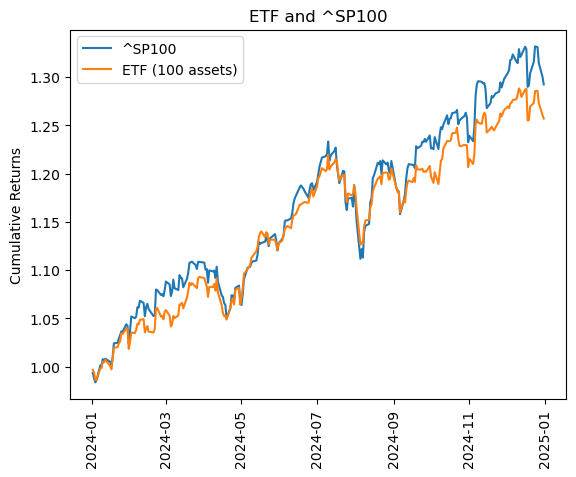

In [6]:
# check out of sample plot
import matplotlib.pyplot as plt

df_test = df_test

print(df_test.columns)
print(tickers)
df_test_mkt = df_test[mkt_index]

r_hat = df_test[tickers].dot(w_hat)

cumret_r = np.cumprod(1+ r_hat)
cumret_mkt = np.cumprod(1+ df_test_mkt)

fig, ax = plt.subplots()
ax.plot(cumret_mkt.index,
        cumret_mkt, 
       label = mkt_index)

ax.plot(cumret_r.index,
        cumret_r,
       label = f"ETF ({n_assets} assets)")

ax.legend()
ax.set_title(f'ETF and {mkt_index}')
ax.set_xlabel('')
ax.set_ylabel('Cumulative Returns')

plt.xticks(rotation = 90)

plt.show()